In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
import pandas as pd
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [2]:
print("TensorFlow version:", tf.__version__)
print("Is GPU available?", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.16.2
Is GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Adatok beolvasása

In [35]:
# Képméret konstansként

image_size = 128

In [36]:
image_data = []
labels = []

train1_dir = './Train1'

for label_folder in tqdm.tqdm(os.listdir(train1_dir)):
    label_path = os.path.join(train1_dir, label_folder)

    if not os.path.isdir(label_path):
        continue
    
    label = label_folder

    for image_file in os.listdir(label_path):
        image_path = os.path.join(label_path, image_file)

        image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        
        image = cv.resize(image, (image_size,image_size))

        
        image_data.append(image)
        labels.append(label)
    
image_data = np.array(image_data)
labels = np.array(labels)

image_data = image_data / 255.0

100%|██████████| 32/32 [00:04<00:00,  7.40it/s]


In [37]:
image_data_train2 = []
labels_train2 = []

train2_dir = './Train2'

for label_folder in tqdm.tqdm(os.listdir(train2_dir)):
    label_path = os.path.join(train2_dir, label_folder)

    if not os.path.isdir(label_path):
        continue

    label = label_folder

    for image_file in os.listdir(label_path):
        image_path = os.path.join(label_path, image_file)

        image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        
        image = cv.resize(image, (image_size, image_size))


        image_data_train2.append(image)
        labels_train2.append(label)

image_data_train2 = np.array(image_data_train2)
labels_train2 = np.array(labels_train2)

image_data_train2 = image_data_train2 / 255.0

100%|██████████| 32/32 [00:03<00:00,  8.53it/s]


In [38]:
# Train1 és Train2 konkatenálása.

image_data  = np.concatenate((image_data, image_data_train2), axis=0)
labels = np.concatenate((labels, labels_train2), axis=0)

In [ ]:
# Megszabadulni a nagyon hasonló különböző osztálybeli képektől SSIM index alapján.
#
# (Nem alkalmaztuk a végső megoldásban)
from skimage.metrics import structural_similarity as ssim

ssim_threshold = 0.985
classes_to_compare = ['Sample001', 'Sample025', 'Sample051']

similar_images = []


for i in tqdm.tqdm(range(len(image_data))):
    if labels[i] in classes_to_compare:
        for j in range(i + 1, len(image_data)):
            if labels[i] != labels[j] and labels[j] in classes_to_compare:
                if any(i in pair or j in pair for pair in similar_images):
                    continue
                score, _ = ssim(image_data[i], image_data[j], full=True, data_range=image_data[i].max() - image_data[i].min())
                if score > ssim_threshold:
                    similar_images.append((i, j))
                    print(f"Image {i} (label {labels[i]}) is very similar to Image {j} (label {labels[j]}).")

In [ ]:
# Kitörölni a nagyon hasonló képeket.

indices_to_remove = set()
for pair in similar_images:
    indices_to_remove.update(pair)

indices_to_remove = sorted(indices_to_remove, reverse=True)

image_data = np.delete(image_data, indices_to_remove, axis=0)
labels = np.delete(labels, indices_to_remove, axis=0)

In [39]:
# Prediktálandó osztályok száma konstansként.

num_classes = np.count_nonzero(np.unique(labels))


In [40]:
# Címkék átalakítása megfelelő integerré. Majd One-hot encoding a to_categorical függvénnyel.

labels_int = np.array([int(label[6:]) for label in labels])
label_encoder = LabelEncoder()
labels_int_encoded = label_encoder.fit_transform(labels_int)
labels_int_categorical = to_categorical(labels_int_encoded, num_classes=num_classes)


In [9]:
# Függvény a beolvasott képek kirajzolására.

def display_images_in_grid(image_data, labels, num_images=10, images_per_row=5):
    
    num_rows = (num_images // images_per_row) + int(num_images % images_per_row != 0)
    
    plt.figure(figsize=(10, num_rows * 2)) 
     
    for i in range(0, num_images):
       
        plt.subplot(num_rows, images_per_row, i + 1)
        
        plt.imshow(image_data[i], cmap='gray')
        
        plt.title(labels[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

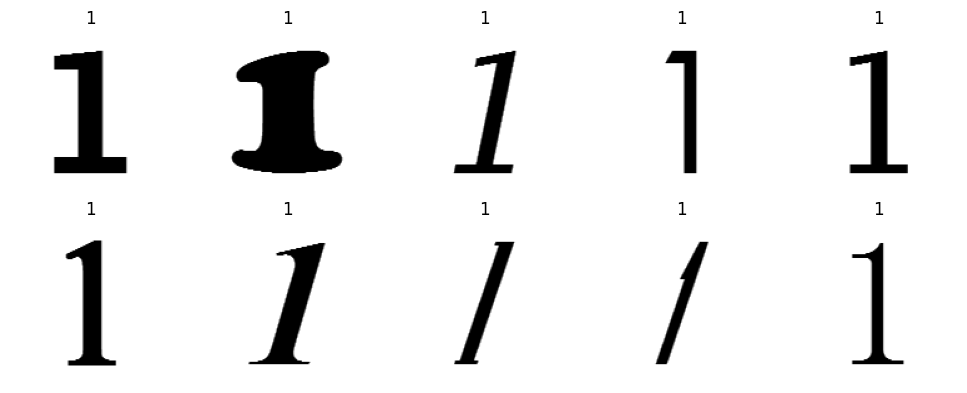

In [10]:
display_images_in_grid(image_data, labels_int_encoded, num_images=10, images_per_row=5)

# Train data felosztása train-test állományra egyenletesen minden címkére

In [41]:
from sklearn.model_selection import StratifiedShuffleSplit

In [42]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data into training and test sets, ensuring proportional stratification for each class
for train_index, test_index in splitter.split(image_data, labels):
    X_train, X_test = image_data[train_index], image_data[test_index]
    y_train, y_test = labels_int_categorical[train_index], labels_int_categorical[test_index]

# Creating the validation set
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for train_index, test_index in splitter2.split(X_test, y_test):
    X_val, X_test2 = X_test[train_index], X_test[test_index]
    y_val, y_test2 = y_test[train_index], y_test[test_index]

# Data Augmentation

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [44]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,    # Képet vízszintesen 10%-kal eltolni
    height_shift_range=0.1,   # Képet függőlegesen 10%-kal eltolni
    shear_range=0.1,          # 10%-os nyírás
    horizontal_flip=False,     # Vízszintes tükrözés nem ajánlott, mert a karakterek irányítottságot hordoznak
    fill_mode='nearest'       # Képek kiegészítése, ha a transzformáció során üres helyek keletkeznek
)

In [45]:
X_train = X_train.reshape((X_train.shape[0], image_size, image_size, 1))
datagen.fit(X_train)

# Modell kialakítása

In [46]:
from keras.layers import Activation,Conv2D,MaxPooling2D,Flatten,Dropout,Dense,BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [ ]:
orai_model = Sequential()

orai_model.add(Conv2D(32,(3,3),padding='valid', input_shape=(image_size, image_size, 1)))
orai_model.add(Activation('relu'))
orai_model.add(Conv2D(32,(3,3)))
orai_model.add(Activation('relu'))
orai_model.add(MaxPooling2D(pool_size=(2,2)))
orai_model.add(Dropout(0.25))

orai_model.add(Conv2D(64,(3,3)))
orai_model.add(Activation('relu'))
orai_model.add(Conv2D(64,(3, 3)))
orai_model.add(Activation('relu'))
orai_model.add(MaxPooling2D(pool_size=(2,2)))
orai_model.add(Dropout(0.25))

orai_model.add(Flatten())
orai_model.add(Dense(512))
orai_model.add(Activation('relu'))
orai_model.add(Dropout(0.5))

orai_model.add(Dense(num_classes))
orai_model.add(Activation('softmax'))

In [18]:
# Általunk tervezett modell 128x128x1-es képekhez, végső megoldásunkban nem ezt használtuk, mivel a másik modellünk jobban teljesített.

uj_model = Sequential()

uj_model.add(Conv2D(32, (3, 3), padding='valid', input_shape=(image_size, image_size, 1)))
uj_model.add(BatchNormalization())
uj_model.add(Activation('relu'))
uj_model.add(Conv2D(32, (3, 3)))
uj_model.add(BatchNormalization())
uj_model.add(Activation('relu'))
uj_model.add(MaxPooling2D(pool_size=(2, 2)))

uj_model.add(Conv2D(64, (3, 3)))
uj_model.add(BatchNormalization())
uj_model.add(Activation('relu'))
uj_model.add(Conv2D(64, (3, 3)))
uj_model.add(BatchNormalization())
uj_model.add(Activation('relu'))
uj_model.add(MaxPooling2D(pool_size=(2, 2)))

uj_model.add(Conv2D(128, (3, 3)))
uj_model.add(BatchNormalization())
uj_model.add(Activation('relu'))
uj_model.add(Conv2D(128, (3, 3)))
uj_model.add(BatchNormalization())
uj_model.add(Activation('relu'))
uj_model.add(MaxPooling2D(pool_size=(2, 2)))

uj_model.add(Flatten())
uj_model.add(Dense(512))
uj_model.add(BatchNormalization())
uj_model.add(Activation('relu'))

uj_model.add(Dense(num_classes))
uj_model.add(Activation('softmax'))


Végleges modell - model128

In [19]:
model128 = Sequential()

# Első konvolúciós blokk
model128.add(Conv2D(32, (5, 5), activation='relu', input_shape=(image_size, image_size, 1)))
model128.add(BatchNormalization())  # Batch normalization
model128.add(MaxPooling2D(pool_size=(2, 2)))

# Második konvolúciós blokk
model128.add(Conv2D(64, (5, 5), activation='relu'))
model128.add(BatchNormalization())  # Batch normalization
model128.add(MaxPooling2D(pool_size=(2, 2)))

# Harmadik konvolúciós blokk
model128.add(Conv2D(128, (4, 4), activation='relu'))
model128.add(BatchNormalization())  # Batch normalization
model128.add(MaxPooling2D(pool_size=(2, 2)))

# Negyedik konvolúciós blokk
model128.add(Conv2D(256, (3, 3), activation='relu'))
model128.add(BatchNormalization())  # Batch normalization
model128.add(MaxPooling2D(pool_size=(2, 2)))


# Kép lelapítása
model128.add(Flatten())

# Teljesen összekapcsolt réteg
model128.add(Dense(512, activation='relu'))
model128.add(Dropout(0.5))  # Dropout réteg a túlilleszkedés csökkentésére

# Kimeneti réteg
model128.add(Dense(num_classes, activation='softmax'))

In [57]:
model = model128
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 124, 124, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 124, 124, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 58, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 58, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 62)             │        31,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,789,502 (14.46 MB)

 Trainable params: 3,788,542 (14.45 MB)

 Non-trainable params: 960 (3.75 KB)

In [49]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [50]:
with tf.device('/GPU:0'):
    model.fit(X_train,y_train,batch_size=32,epochs=200,verbose=1,validation_data=(X_test2,y_test2),callbacks=[early_stopping])

Epoch 1/200
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.5170 - loss: 1.8126 - val_accuracy: 0.8426 - val_loss: 0.4372
Epoch 2/200
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.8156 - loss: 0.5280 - val_accuracy: 0.8661 - val_loss: 0.3591
Epoch 3/200
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.8339 - loss: 0.4382 - val_accuracy: 0.8686 - val_loss: 0.3270
Epoch 4/200
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.8499 - loss: 0.3872 - val_accuracy: 0.8847 - val_loss: 0.2927
Epoch 5/200
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.8600 - loss: 0.3504 - val_accuracy: 0.8849 - val_loss: 0.2753
Epoch 6/200
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.8683 - loss: 0.3295 - val_accuracy: 0.8934 - val_loss: 0.2684
Epoch 7/200
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.8772 - loss: 0.3095 - val_accuracy: 0.8983 - val_loss: 0.2532
Epoch 8/200
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 

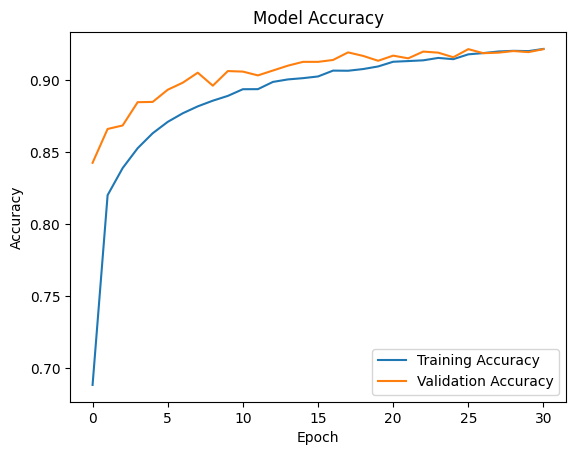

In [51]:
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Próbálkozás dimenziócsökkentéssel és más modellekkel.

import umap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=15)
X_train_umap = umap_model.fit_transform(X_train_flattened)
X_test_umap = umap_model.transform(X_test_flattened)

knn = KNeighborsClassifier(n_neighbors=20)

knn.fit(X_train_umap, y_train)

svm_pred = knn.predict(X_test_umap)
accuracy = accuracy_score(y_test, svm_pred)

accuracy

In [ ]:
# Súlyok kimentése fájlba
model.save_weights("best.weights.h5")


In [ ]:
# Súlyok betöltése fájlból
model.load_weights("best.weights.h5")

# Modell visszamérése

In [23]:
from sklearn.metrics import confusion_matrix

In [52]:
pred = model.predict(X_val)
pred_labels = np.argmax(pred, axis=1)
true_labels = np.argmax(y_val, axis=1)

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [53]:
total_accuracy = np.mean(pred_labels == true_labels)
total_accuracy

0.922512695128832

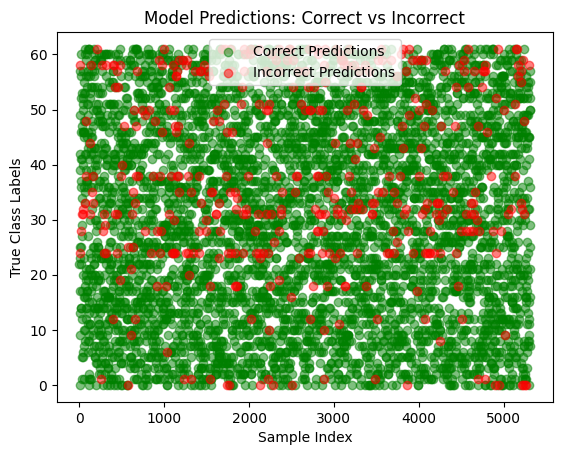

In [56]:
# Find correct and incorrect predictions
correct_indices = np.where(pred_labels == true_labels)[0]
incorrect_indices = np.where(pred_labels != true_labels)[0]

plt.scatter(correct_indices, true_labels[correct_indices], color='green', label='Correct Predictions', alpha=0.5)

plt.scatter(incorrect_indices, true_labels[incorrect_indices], color='red', label='Incorrect Predictions', alpha=0.5)

plt.xlabel('Sample Index')
plt.ylabel('True Class Labels')
plt.title('Model Predictions: Correct vs Incorrect')
plt.legend()

plt.show()

# Kideríteni, melyik osztályokban hibázik a modell nagyot, és ott mit tippel.

In [54]:
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Calculate accuracy for each class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_names = [f'Class {i}' for i in range(len(class_accuracy))]
class_accuracy_dict = dict(zip(class_names, class_accuracy))

# Filter classes with accuracy below x%
low_accuracy_classes = {class_name: accuracy for class_name, accuracy in class_accuracy_dict.items() if accuracy < 0.80}

cnt = 0
for class_name, accuracy in low_accuracy_classes.items():
    cnt += 1
    print(f"{class_name}: {accuracy:.2f}")

print("Összesen: " + str(cnt) + " db")

Class 24: 0.50
Class 28: 0.71
Class 31: 0.60
Class 38: 0.65
Class 57: 0.73
Class 58: 0.78
Class 61: 0.71
Összesen: 7 db


In [55]:
low_accuracy_predictions = []

for class_name in low_accuracy_classes.keys():
    class_index = int(class_name.split(' ')[-1])
    class_indices = np.where(true_labels == class_index)[0] 
    
    for idx in class_indices:
        if pred_labels[idx] != true_labels[idx]: 
            low_accuracy_predictions.append({
                'Index': idx,
                'True Label': true_labels[idx] + 1, # Azért kell +1, hogy a megfelelő SampleXXX-t lehessen megkapni.
                'Predicted Label': pred_labels[idx] + 1
            })

low_accuracy_df = pd.DataFrame(low_accuracy_predictions)

low_accuracy_df

,Index,True Label,Predicted Label
0,1,25,1
1,295,25,51
2,317,25,1
3,442,25,51
4,847,25,1
...,...,...,...
184,3881,62,36
185,4582,62,36
186,4932,62,36
187,5148,62,36


# Teszt képek

Végleges predikció meghatározása a TestData adathalmazra

In [48]:
test_image_data = []
test_labels = []

test_dir = './TestData'


for image_file in sorted(os.listdir(test_dir)):
    image_path = os.path.join(test_dir, image_file)

    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

    if image is None:
        continue
        
    image = cv.resize(image, (image_size,image_size))

    test_image_data.append(image)
    test_labels.append(image_file)
    
test_image_data = np.array(test_image_data)

test_image_data = test_image_data / 255.0

In [ ]:
test_pred = model.predict(test_image_data)
test_pred_labels = np.argmax(test_pred, axis=1) + 1

In [ ]:
data_to_save = np.column_stack((test_pred_labels, test_labels))
data_to_save

In [52]:
np.savetxt(
    "predictions.txt",
    data_to_save,
    fmt='%s',
    delimiter=';'
)

# Pretrained model

In [54]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))

base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model_pretrained = Model(inputs=base_model.input, outputs=output)

model_pretrained.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model_pretrained.fit(X_train,y_train,batch_size=32,epochs=50,verbose=1,validation_data=(X_test,y_test),callbacks=[early_stopping])



# A VGG-16-os modellhez kapcsolódó kódunkat a félév során kitöröltük, így aztnem tudjuk feltüntetni.